In [1]:
import pandas as pd
import numpy as np
from google.cloud import storage
from tqdm.notebook import tqdm
import openslide
import tifffile

# General imports
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

try:
    import plotly.express as px
except:
    !pip install -q plotly
    import plotly.express as px

import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import openslide
import tifffile
import random
import math
import cv2
import os
import gc

CLASS_CPAL = sns.color_palette("bright", 7)
display(CLASS_CPAL)
CLASS_CPAL = np.uint8(np.array(CLASS_CPAL)*255)
CLASS_CPAL

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392)]

array([[  2,  62, 255],
       [255, 124,   0],
       [ 26, 201,  56],
       [232,   0,  11],
       [139,  43, 226],
       [159,  72,   0],
       [241,  76, 193]], dtype=uint8)

In [11]:
to_move = ["out_of_focus", "no_tissue"]
df = pd.read_csv("subset_1_2_3_4_combined.csv", names=["subset", "path", "label"], skiprows=1)
df["label"] = df.a

subset                                               path  \
0      TRAIN  gs://seagen-quantiphi/subset_1_1/export_data-s...   
1      TRAIN  gs://seagen-quantiphi/subset_1_1/export_data-s...   
2      TRAIN  gs://seagen-quantiphi/subset_1_1/export_data-s...   
3      TRAIN  gs://seagen-quantiphi/subset_1_1/export_data-s...   
4      TRAIN  gs://seagen-quantiphi/subset_1_1/export_data-s...   
...      ...                                                ...   
22262   TEST  gs://seagen-quantiphi/subset_1_4/export_data-s...   
22263  TRAIN  gs://seagen-quantiphi/subset_1_4/export_data-s...   
22264  TRAIN  gs://seagen-quantiphi/subset_1_4/export_data-s...   
22265  TRAIN  gs://seagen-quantiphi/subset_1_4/export_data-s...   
22266  TRAIN  gs://seagen-quantiphi/subset_1_4/export_data-s...   

                 label  
0         out_of_focus  
1         dim_positive  
2                   HE  
3         dim_positive  
4         out_of_focus  
...                ...  
22262     out_of_focus  
22263        no_tissue  
22264  strong_positive  
22265        no_tissue  
22266        no_tissue  

[22267 rows x 3 columns]

In [2]:
def get_paths(path_to_folder):
    """ Simple function to return full paths of all svs and qptiff images in a folder """
    if not os.path.isdir(path_to_folder):
        print(f"Skipping as `{path_to_folder}` folder does not exist")
        return []
    
    return [
        path for path in \
        [os.path.join(path_to_folder, f_name) for f_name in os.listdir(path_to_folder)] \
        if (path[-4:] == ".svs" or path[-6:] == "qptiff")
    ]

def get_path_from_ss(path_list, ss):
    return [path for path in path_list if ss in path][0]

In [3]:
# Define base paths
path_to_focus = "/home/jupyter/data/Focus/Out_Focus"
path_to_tissue = "/home/jupyter/data/Tissue/No_Tissue"
path_to_stained = "/home/jupyter/data/Stained"
path_to_he = "/home/jupyter/data/H&E"
path_to_dim = os.path.join(path_to_stained, "Dim")
path_to_no = os.path.join(path_to_stained, "No")
path_to_yes = os.path.join(path_to_stained, "Yes")

# Download csvs if necessary
if not os.path.isfile("visualization_files/image_classification_1.csv"):
    !gsutil -m cp -r gs://seagen-quantiphi/subset_1_1/export_data-seagen_subset_1_1-2020-12-23T08:55:47.943745Z/image_classification_1.csv visualization_files/image_classification_1.csv
    !gsutil -m cp -r gs://seagen-quantiphi/subset_1_2/export_data-seagen_subset_1_2-2021-01-08T08:10:51.904341Z/image_classification_1.csv visualization_files/image_classification_2.csv
    !gsutil -m cp -r gs://seagen-quantiphi/subset_1_3/export_data-seagen_subset_1_3-2021-01-08T10:51:42.591419Z/image_classification_1.csv visualization_files/image_classification_3.csv
    !gsutil -m cp -r gs://seagen-quantiphi/export_data-seagen_subset_1_4-2021-01-11T12:38:12.863975Z/image_classification_1.csv visualization_files/image_classification_4.csv

In [4]:
# Get full paths to various image classes
oof_paths = get_paths(path_to_focus)
stn_yes_paths = get_paths(path_to_yes)
stn_dim_paths = get_paths(path_to_dim)
stn_no_paths = get_paths(path_to_no)
no_tis_paths = get_paths(path_to_tissue)
he_tis_paths = get_paths(path_to_he)
ALL_PATHS = oof_paths+stn_yes_paths+stn_dim_paths+no_tis_paths+he_tis_paths+stn_no_paths

# Visualize No Tissue on Slide
print(f"\n\nALL IMAGE PATHS   –   There are {len(ALL_PATHS)} All Files\n")
print(ALL_PATHS[:2]+["etc..."])
print("\n")



ALL IMAGE PATHS   –   There are 240 All Files

['/home/jupyter/data/Focus/Out_Focus/41752.svs', '/home/jupyter/data/Focus/Out_Focus/42684.svs', 'etc...']




In [5]:
name_map_df = pd.concat([
    pd.read_csv("tiles/name_map_first_60.csv"),
    pd.read_csv("tiles/name_map_200_to_206_he.csv")
])
name_map_df["full_path"] = name_map_df["full_path"].apply(lambda x: x.split(".", 1)[0])
name_map_df["alias"] = name_map_df["alias"].apply(lambda x: x.split(".", 1)[0])
name_map_df

original_2_alias = {original:alias for original, alias in zip(name_map_df.full_path.values, name_map_df.alias.values)}
alias_2_original = {v:k for k,v in original_2_alias.items()}

df = pd.concat([
    pd.read_csv("visualization_files/image_classification_1.csv", names=["subset", "path", "label"]),
    pd.read_csv("visualization_files/image_classification_2.csv", names=["subset", "path", "label"]),
    pd.read_csv("visualization_files/image_classification_3.csv", names=["subset", "path", "label"]),
    pd.read_csv("visualization_files/image_classification_4.csv", names=["subset", "path", "label"])
]).reset_index(drop=True)

df["bucket_name"] = df["path"].apply(lambda x: x[5:].split("/", 1)[0])
df["blob_name"] = df["path"].apply(lambda x: x[5:].split("/", 1)[1])
df.drop(columns=["subset", "path"], inplace=True)

df

label       bucket_name  \
0         out_of_focus  seagen-quantiphi   
1         dim_positive  seagen-quantiphi   
2                   HE  seagen-quantiphi   
3         dim_positive  seagen-quantiphi   
4         out_of_focus  seagen-quantiphi   
...                ...               ...   
22262     out_of_focus  seagen-quantiphi   
22263        no_tissue  seagen-quantiphi   
22264  strong_positive  seagen-quantiphi   
22265        no_tissue  seagen-quantiphi   
22266        no_tissue  seagen-quantiphi   

                                               blob_name  
0      subset_1_1/export_data-seagen_subset_1_1-2020-...  
1      subset_1_1/export_data-seagen_subset_1_1-2020-...  
2      subset_1_1/export_data-seagen_subset_1_1-2020-...  
3      subset_1_1/export_data-seagen_subset_1_1-2020-...  
4      subset_1_1/export_data-seagen_subset_1_1-2020-...  
...                                                  ...  
22262  export_data-seagen_subset_1_4-2021-01-11T12:38...  
22263  export_data-seagen_subset_1_4-2021-01-11T12:38...  
22264  export_data-seagen_subset_1_4-2021-01-11T12:38...  
22265  export_data-seagen_subset_1_4-2021-01-11T12:38...  
22266  export_data-seagen_subset_1_4-2021-01-11T12:38...  

[22267 rows x 3 columns]

In [63]:
def get_metadata(row):
    storage_client = storage.Client()
    bucket = storage_client.bucket(row["bucket_name"])
    try:
        blob = bucket.get_blob(row["blob_name"])
        meta = blob.metadata
        row["x_coord"] = int(meta["x_coord"])
        row["y_coord"] = int(meta["y_coord"])
        row["slide_name"] = meta["slide_name"]
        row["slide_label"] = meta["slide_label"]
        if row.name%250==0:
            print(f"Row {row.name}/22267 Complete")
    except:
        print(f'Problem at {row["bucket_name"]} - {row["blob_name"]}')
    return row

if not os.path.isfile("./visualization_files/updated_meta.csv"):
    df = df.apply(get_metadata, axis=1)
    df.label.fillna(df.slide_label, inplace=True)
    df.label = df.label.str.lower()
    df["slide_name_original"] = df["slide_name"].apply(lambda x: alias_2_original[x])
else:
    df = pd.read_csv("./visualization_files/updated_meta.csv")

df

label       bucket_name  \
0         out_of_focus  seagen-quantiphi   
1         dim_positive  seagen-quantiphi   
2                   he  seagen-quantiphi   
3         dim_positive  seagen-quantiphi   
4         out_of_focus  seagen-quantiphi   
...                ...               ...   
22262     out_of_focus  seagen-quantiphi   
22263        no_tissue  seagen-quantiphi   
22264  strong_positive  seagen-quantiphi   
22265        no_tissue  seagen-quantiphi   
22266        no_tissue  seagen-quantiphi   

                                               blob_name  x_coord  y_coord  \
0      subset_1_1/export_data-seagen_subset_1_1-2020-...    24576    35840   
1      subset_1_1/export_data-seagen_subset_1_1-2020-...     6144    10240   
2      subset_1_1/export_data-seagen_subset_1_1-2020-...    20480    25600   
3      subset_1_1/export_data-seagen_subset_1_1-2020-...     9216    22528   
4      subset_1_1/export_data-seagen_subset_1_1-2020-...    19456    14336   
...                                                  ...      ...      ...   
22262  export_data-seagen_subset_1_4-2021-01-11T12:38...    46080    21504   
22263  export_data-seagen_subset_1_4-2021-01-11T12:38...    20480     5120   
22264  export_data-seagen_subset_1_4-2021-01-11T12:38...     4096    15360   
22265  export_data-seagen_subset_1_4-2021-01-11T12:38...     1024    16384   
22266  export_data-seagen_subset_1_4-2021-01-11T12:38...    28672    34816   

      slide_name      slide_label  \
0        img_006     out_of_focus   
1        img_020  strong_positive   
2        img_010     out_of_focus   
3        img_042     dim_positive   
4        img_007     out_of_focus   
...          ...              ...   
22262    img_001     out_of_focus   
22263    img_011     out_of_focus   
22264    img_013  strong_positive   
22265    img_057        no_tissue   
22266    img_053        no_tissue   

                                  slide_name_original  
0                                               41755  
1        SGN023_APD ML0911177B 20200423 avb6 ^1187084  
2                                               42680  
3      SGN010B_APD ML1104236B 20191112 CD228 ^1131961  
4                                               42682  
...                                               ...  
22262                                           42684  
22263                                           42677  
22264  SGN010B_APD ML1407166A 20191107 CD228 ^1132440  
22265                                           29890  
22266                                           29852  

[22267 rows x 8 columns]

In [118]:
def create_overlay(df, output_dir, path_to_slide, slide_label,
                   max_size=1920, 
                   class_cpal=None, 
                   display=False, 
                   verbose=False, 
                   use_builtin_dwnsample=True, 
                   class_list=('out_of_focus', 'dim_positive', 'he', 'negative', 'no_tissue', 'necrotic', 'strong_positive'), 
                   core_opacity=0.65,
                   cmap_name="bright", 
                   original_tile_size=1024,
                   figure_dpi=120):
    """ Create an Overlay Showing The Tile Level Predictions
    
    Args:
        df (pd.DataFrame): Containing: x_coord (int), y_coord (int), label (str)
        output_dir (str): Path to the directory to save the overlay
        path_to_slide (str): Path to the slide (on local where it can be loaded)
        slide_label (str): The label to apply to the entire slide.
        max_size (int, optional): The maximum side length to constrain the overlay's longest side to
        class_cpal (np.array, optional): Included color palette to use for overlay
        display (bool, optional): Whether to display the generated overlay
        use_builtin_dwnsample (bool, optional): Whether to load using OpenSlide's
            builtin downsample functionality (STRONGLY RECOMMENDED)
        class_list (tuple, optional): List of classes to be used that will tie the 
            label in the df to a specific colour in the legend/color-palette
        core_opacity (float, optional): Opacity of the slide image (alpha)
            i.e 1-core_opacity will give you the opacity of the label-color-map
        cmap_name (str, optional): Name of the seaborn color palette to use.
            LINK --> https://seaborn.pydata.org/tutorial/color_palettes.html
        original_tile_size (int, optional): Original size of the tiles that were 
            predicted upon by the model
        figure_dpi (int, optional): The resolution for which to save the 
            matplotlib figure with
            
    Returns:
        None; An image will be written to disk containing the overlay
              and the image can also be displayed (optional)
        
    
    """
    
    
    
    # ##############################################################################    
    #                      Initialize Display Related Things
    # ##############################################################################
    
    
    # Color Palette As A List
    cpal_map = sns.color_palette(cmap_name, len(class_list))
    
    # Get Color Palette Values in the Right Format [0-255 and uint8]
    if class_cpal is None:
        class_cpal = np.uint8(np.array(cpal_map)*255)
    
    # Map each class to a specific color value
    class_cmap = {c:class_cpal[i] for i,c in enumerate(class_list)}
    
    # Create legend elements to be used later when plotting
    legend_elements = [
        Patch(facecolor=np.append(c,1-core_opacity), label=class_list[i]) \
        for i,c in enumerate(cpal_map)
    ]
    legend_elements.append(Patch(facecolor=(0,0,0,1-core_opacity), label="background"))
    
    # ##############################################################################
    
    
    
    # ##############################################################################        
    #                     Creating the Downsampled Slide Image                     #
    # ##############################################################################
    
    
    # ######################## #
    # ###   Step 1. Load   ### #
    # ######################## #

    # Get the full slide as an OpenSlide object
    full_slide = openslide.OpenSlide(slide_path)

    
    # ################################################## #
    # ### Step 2. Get Values Related to Downsampling ### #
    # ################################################## #
    
    # If we want to use built in downsampling we set these parameters accordingly
    if use_builtin_dwnsample:
        level_idx = full_slide.level_count-1               # Downsample Level Index
        start_dwnsample = full_slide.level_downsamples[-1] # Amount to Downsample
        slide_dim = full_slide.level_dimensions[-1]        # Get Dimensions of Downsampled Slide
    else:
        level_idx = 0                     # Pick the first index
        start_dwnsample=1                 # Amount to downsample is 1 (None)
        slide_dim = full_slide.dimensions # Downsampled Slide Dims Are Original Dims
    
    # Print text on characteristics of slide if requested (verbose=True)
    if verbose:
        print(f"ORIGINAL SLIDE DIMENSIONS: {full_slide.dimensions}")
        if use_builtin_dwnsample:
            print(f"DOWNSAMPLED SLIDE DIMENSIONS: {slide_dim}")
    
    
    # ##################################### #
    # ### Step 3. Get Downsample Factor ### #
    # ##################################### #
    
    downscale_factor = max(slide_dim)/max_size
    total_downscale_factor = downscale_factor*start_dwnsample
    
    # Print text on characteristics of slide if requested (verbose=True)
    if verbose:
        print("DOWNSCALE FACTOR: ", total_downscale_factor)
    
    # ################################# #
    # ### Step 4. Get New Tile Size ### #
    # ################################# #
    
    new_tile_size = int(np.ceil(original_tile_size/(total_downscale_factor)))
    
    # Print text on characteristics of slide if requested (verbose=True)
    if verbose:
        print(f"ORIGINAL TILE DIMENSIONS: {original_tile_size}x{original_tile_size}")
        print(f"NEW TILE DIMENSIONS: {new_tile_size}x{new_tile_size}")
    
    
    # ############################################ #
    # ### Step 5. Get Display Image Dimensions ### #
    # ############################################ #
    
    slide_new_dim = (int(slide_dim[0]/downscale_factor), int(slide_dim[1]/downscale_factor))
    
    # Print text on characteristics of slide if requested (verbose=True)
    if verbose:
        print("NEW SLIDE DIMENSIONS: ", slide_new_dim)
    

    # ####################################### #
    # ### Step 6. Conduct the Downscaling ### #
    # ####################################### #
    
    # Indicate that this may take a while if requested (verbose=True)
    if verbose:
        print("\n... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...\n")    
    
    # Load the region --> Convert from RGBA to RGB --> Covert to UINT8 ...
    region = np.asarray(
        full_slide.read_region(location=(0,0), 
                               level=level_idx, 
                               size=slide_dim).convert('RGB'), 
        dtype=np.uint8)
    
    # ... --> Resize the region to the new slide dimensions
    dwn_slide = cv2.resize(region, (slide_new_dim))
    

    # ##############################################################################
    
    
    
    # ##############################################################################        
    #                        Creating the Label Color Map                          #
    # ##############################################################################
    
    
    # ############################################## #
    # ### Step 1. Initialize the Label Color Map ### #
    # ############################################## #
    
    #      - all squares are assumed to be background to begin with (0)
    c_lbl_map = np.zeros((slide_new_dim[1], slide_new_dim[0], 3), dtype=np.uint8)
    
    
    # ##################################################### #
    # ### Step 2. Loop Over DF & Update Label Color Map ### #
    # ##################################################### #
    
    for xmin, ymin, label in df.to_numpy():
        # Approximate Top-Left Corner X Value
        xmin = int(np.round(xmin/total_downscale_factor)) 
        
        # Approximate Top-Left Corner Y Value
        ymin = int(np.round(ymin/total_downscale_factor))
        
        # Approximate Top-Left Corner X Value
        c_lbl_map[ymin:ymin+new_tile_size, xmin:xmin+new_tile_size, :] = class_cmap[label]
    
    
    # ##############################################################################
    
    
    
    # ##############################################################################        
    #                Creating the Merged Image, Plotting and Saving                #
    # ##############################################################################
    
    
    # ######################################################### #
    # ### Step 1. Merge/Overlay the Slide & Label Color Map ### #
    # ######################################################### #
    overlayed_img = cv2.addWeighted(dwn_slide, core_opacity, c_lbl_map, 1-core_opacity, 1)
    
    
    # ########################################################### #
    # ### Step 2. Setup The Matplotlib Figure, Legend & Title ### #
    # ########################################################### #
    plt.figure(figsize=(20,20*(slide_new_dim[1]/slide_new_dim[0])))
    plt.imshow(overlayed_img)
    plt.legend(handles=legend_elements)
    plt.title(f"{path_to_slide} – SLIDE LEVEL LABEL IS {slide_label}", fontweight="bold")
    
    
    # ################################################# #
    # ### Step 3. Get Output Path & Save the Figure ### #
    # ################################################# #
    out_path = os.path.join(output_dir, path_to_slide.rsplit("/", 1)[1].rsplit(".", 1)[0]+".png")
    plt.savefig(out_path, bbox_inches='tight', dpi=figure_dpi)
    
    # Print where the file was saved if requested (verbose=1)
    if verbose:
        print(f"FILE SAVED TO --> {out_path}")
    
    # ############################################## #
    # ### Step 4. Display the Image If Requested ### #
    # ############################################## #
    if display:
        plt.show()

In [115]:
# df["slide_label"][df.slide_name_original=="82_F00038301_HE"] = "he"
# df[df.slide_name_original=="82_F00038301_HE"]

ORIGINAL SLIDE DIMENSIONS: (43824, 37168)
DOWNSAMPLED SLIDE DIMENSIONS: (2739, 2323)
DOWNSCALE FACTOR:  22.825
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 45x45
NEW SLIDE DIMENSIONS:  (1920, 1628)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/41755.png


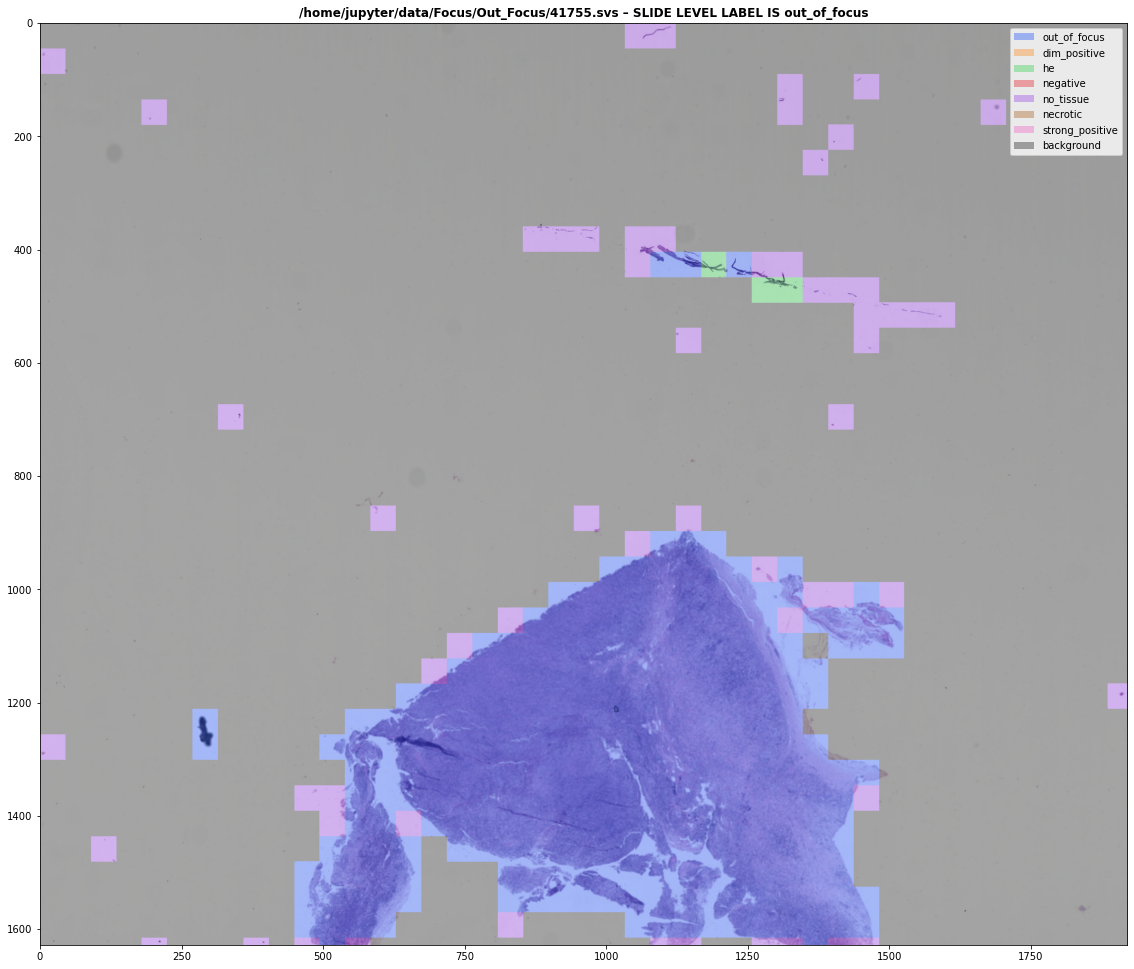

ORIGINAL SLIDE DIMENSIONS: (17928, 16061)
DOWNSAMPLED SLIDE DIMENSIONS: (2241, 2007)
DOWNSCALE FACTOR:  9.33895389573991
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 110x110
NEW SLIDE DIMENSIONS:  (1920, 1719)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/SGN023_APD ML0911177B 20200423 avb6 ^1187084.png


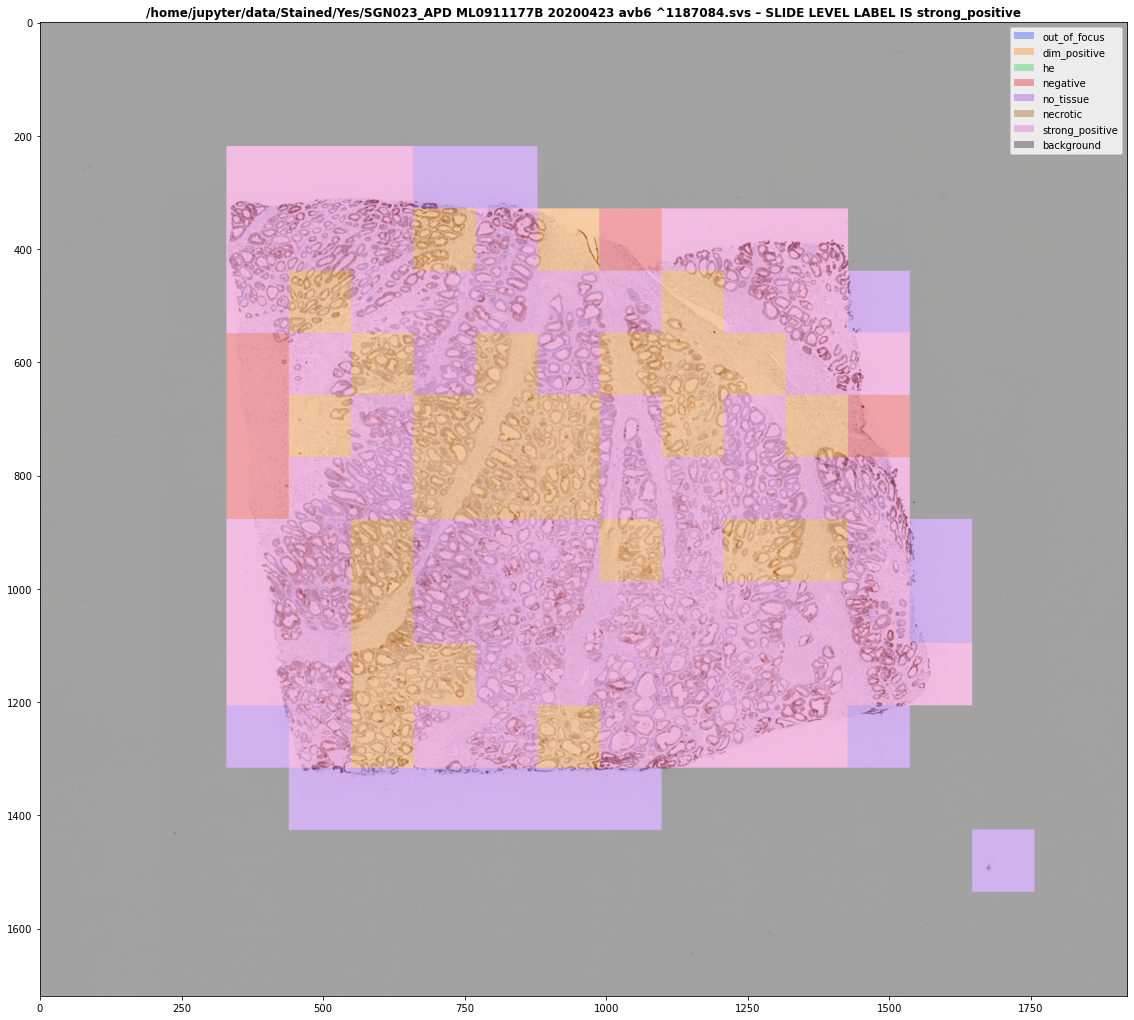

ORIGINAL SLIDE DIMENSIONS: (37848, 31966)
DOWNSAMPLED SLIDE DIMENSIONS: (2365, 1997)
DOWNSCALE FACTOR:  19.714734341094978
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 52x52
NEW SLIDE DIMENSIONS:  (1920, 1621)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/SGN010B_APD ML1104236B 20191112 CD228 ^1131961.png


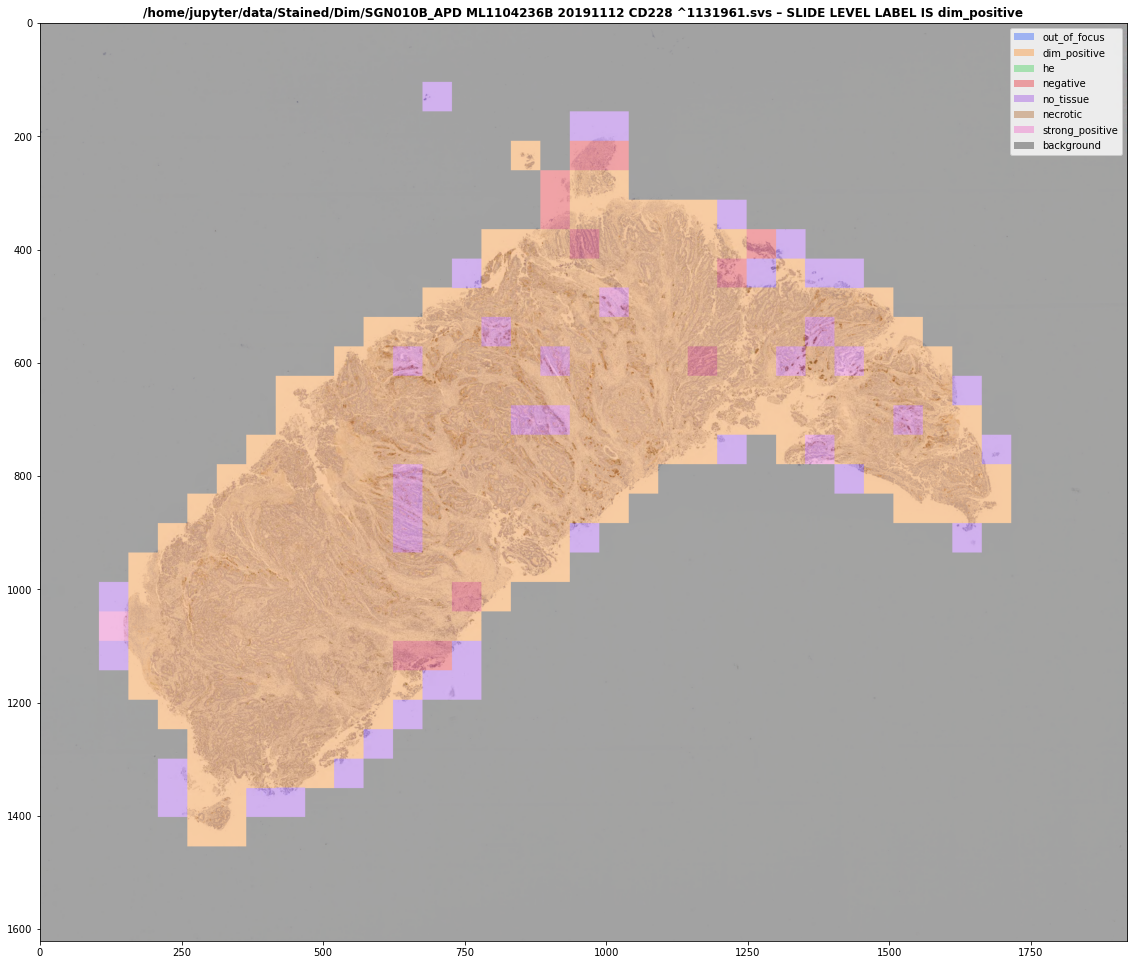

ORIGINAL SLIDE DIMENSIONS: (29880, 29915)
DOWNSAMPLED SLIDE DIMENSIONS: (1867, 1869)
DOWNSCALE FACTOR:  15.579950148410996
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 66x66
NEW SLIDE DIMENSIONS:  (1917, 1920)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/SGN023_APD ML1404011E 20200406 avb6 NCR DF4000^1174421.png


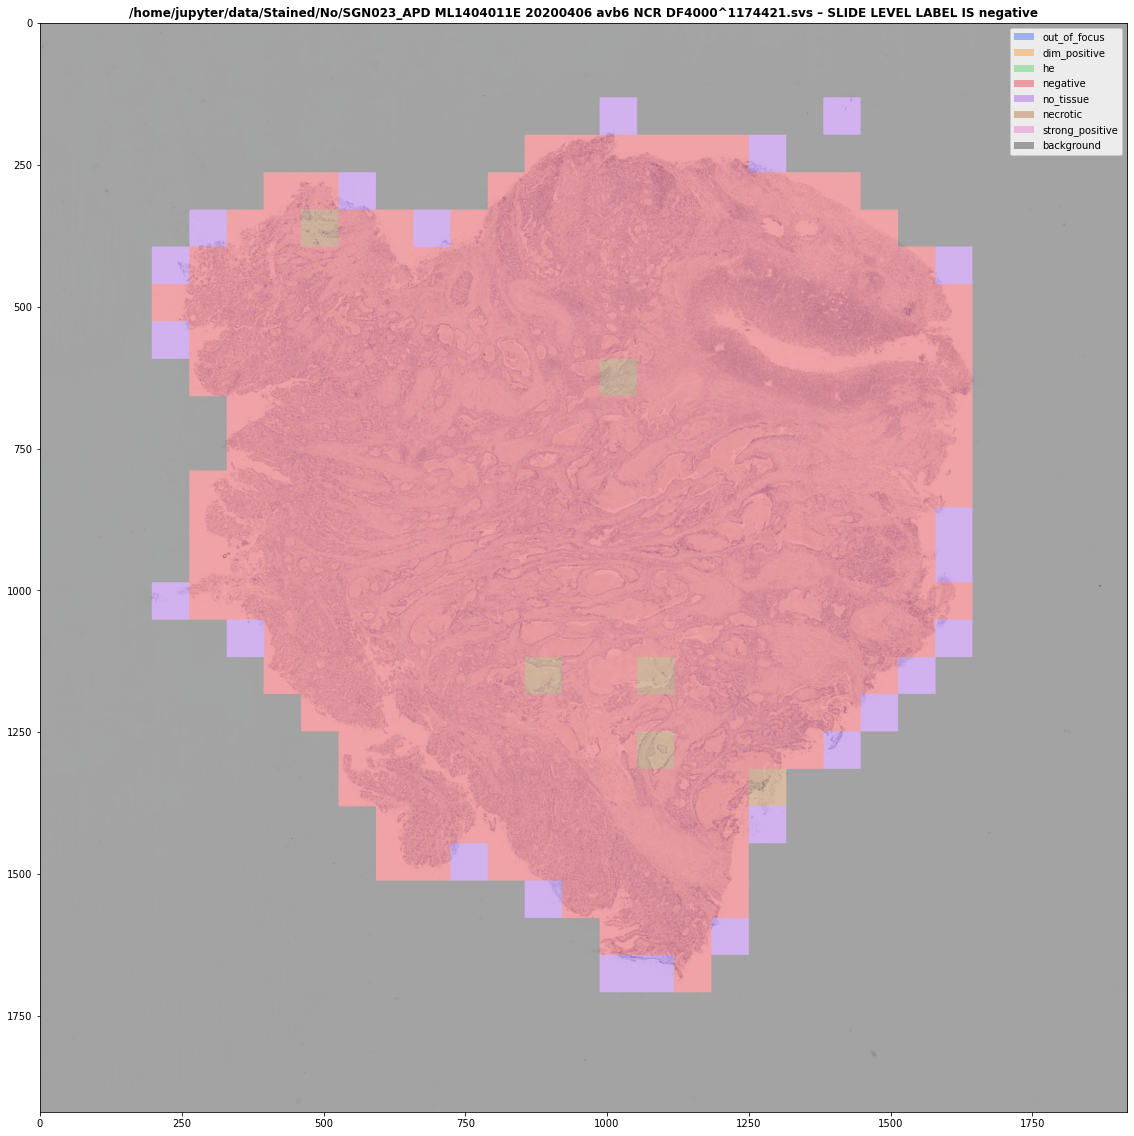

ORIGINAL SLIDE DIMENSIONS: (85656, 44250)
DOWNSAMPLED SLIDE DIMENSIONS: (2676, 1382)
DOWNSCALE FACTOR:  44.61936052821997
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 23x23
NEW SLIDE DIMENSIONS:  (1920, 991)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/29856.png


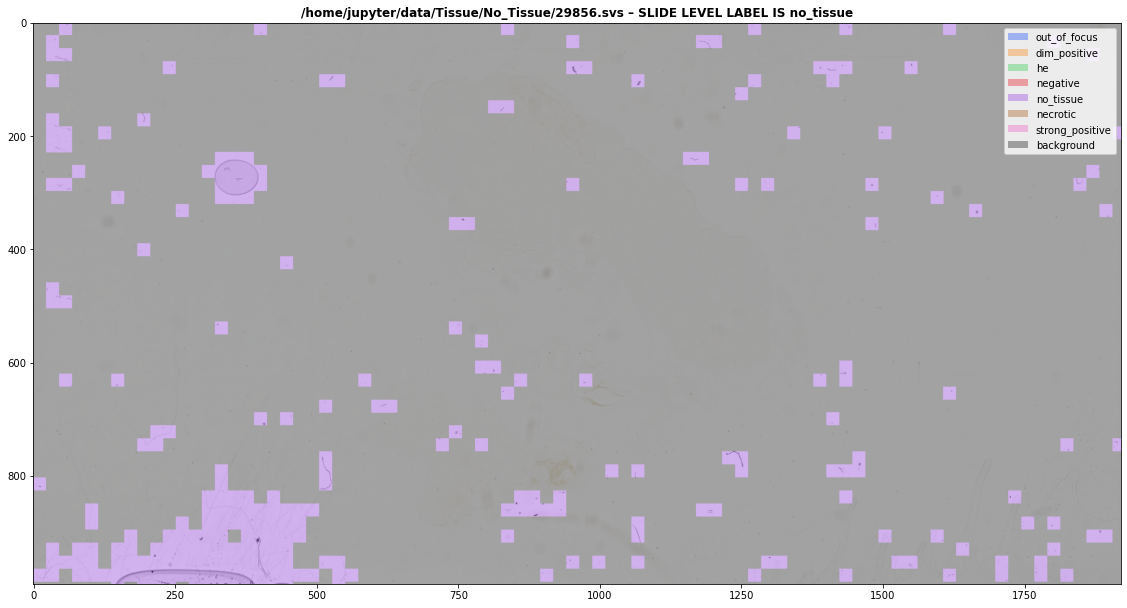

ORIGINAL SLIDE DIMENSIONS: (56168, 44206)
DOWNSAMPLED SLIDE DIMENSIONS: (3510, 2762)
DOWNSCALE FACTOR:  29.25671652486121
ORIGINAL TILE DIMENSIONS: 1024x1024
NEW TILE DIMENSIONS: 36x36
NEW SLIDE DIMENSIONS:  (1920, 1510)

... STARTING LOAD AND RESIZE - WILL TAKE 15-60 SECONDS ON AVERAGE ...

FILE SAVED TO --> /home/jupyter/visualization_files/82_F00038301_HE.png


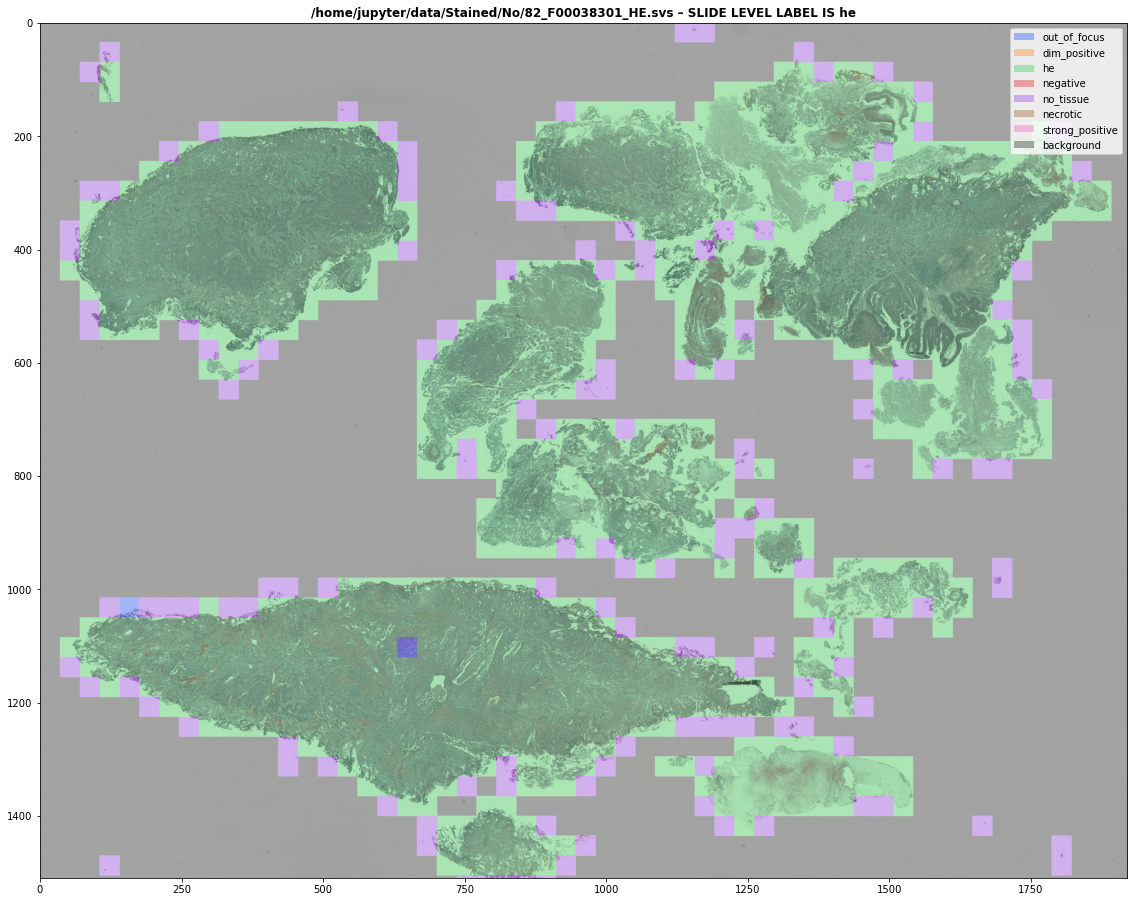

In [131]:
for f_name, slide_label in df.drop_duplicates(subset=["slide_label"])[["slide_name_original", "slide_label"]].values:
    # CREATE PRETEND CSV
    pretend_csv_df = df[df.slide_name_original==f_name]
    pretend_csv_df = pretend_csv_df[[ "x_coord", "y_coord", "label"]].reset_index(drop=True)

    # Get the slide path (may need to tweak this fn depending on instance)
    slide_path = get_path_from_ss(ALL_PATHS, f_name)
    create_overlay(pretend_csv_df, "/home/jupyter/visualization_files", 
                   path_to_slide=slide_path, max_size=1920, slide_label=slide_label,
                   core_opacity=0.666, display=True, figure_dpi=100, verbose=True)